In [44]:
from pymongo import MongoClient, ASCENDING
client = MongoClient('localhost', 27017)
db = client["text_mining"]
mongo_comments = db["comments"]
mongo_posts = db["posts"]
post_ids = mongo_comments.distinct('post_id')

In [45]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

new_words = {
    "bull": 1,
    "bullish": 1,
    "moon": 1,
    "calls": 1,
    "bear": -1,
    "bearish": -1,
    "green": 1,
    "red": -1,
    "tank": -1,
    "puts": -1
}
sid.lexicon.update(new_words)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/benjamin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:

def analyze_comments(comments):
    score = []
    for comment in comments:
        score.append(sid.polarity_scores(comment["body"]))
    return score

def analyze_text(text):
    return sid.polarity_scores(text)

In [47]:
def analyze_score_individual_comments(scores):
    total_ammount_negative, total_ammount_positive, 
    total_polarity_positive, total_polarity_negative = 0

    for score in scores:
        ammount_negative, ammount_positive,
        ammount_neutral, polarity = 0
        
        for entry in score:
            if entry["compound"] > 0:
                ammount_positive += 1
            elif entry["compond"] == 0:
                ammount_neutral += 1
            else:
                ammount_negative += 1
            polarity += entry["compound"]
                
        if negative < positive:
            total_ammount_positive += 1
        elif positive < negative:
            total_ammount_negative += 1
        if polarity > 0:
            total_polarity_positive += 1
        elif polarity < 0:
            total_polarity_negative += 1  
    return total_ammount_positive, total_ammount_negative, total_polarity_positive, total_polarity_negative
        
def analyze_score_combined_comments(scores):
    total_negative = 0
    total_positive = 0
    for score in scores:
        if score["compound"] > 0:
            total_positive += 1
        elif score["compound"] < 0:
            total_negative += 1
    return total_negative, total_positive

## Add sentiment score to all comments

In [9]:
count = 0
for post_id in post_ids:
    
    post = mongo_posts.find({"id": post_id})[0]
    comments = mongo_comments.find({"post_id": post_id})
    for comment in comments:
        count += 1
        if count % 1000 == 0:
            print(f"Updating comment number {count}")
        polarity_score = sid.polarity_scores(comment["body"])
        mongo_comments.update_one({"id": comment["id"],"post_id": post_id},{"$set": {"sentiment_score": polarity_score}})



# ALPHA VANTAGE download

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas
API_KEY = "M8RF5RFRF8PG32I1"
ts = TimeSeries(key="M8RF5RFRF8PG32I1", output_format='pandas')
res = ts.get_daily_adjusted(symbol="SPY", outputsize="full")[0]
res = res.drop(["1. open", "2. high", "3. low", "4. close", "6. volume", "7. dividend amount", "8. split coefficient"], axis=1)
res = res.rename(columns={'5. adjusted close': "close"})


## Add close price to comments

In [ ]:
from datetime import datetime, timedelta
from pytz import timezone

one_day_offset = timedelta(days=1)

for post_id in post_ids:
    post = mongo_posts.find({"id": post_id})[0]
    comments = mongo_comments.find({"post_id": post_id})
    for comment in comments:
        start_day = datetime.fromtimestamp(comment["created_utc"]).date()
        
        date = datetime.fromtimestamp(comment["created_utc"]).date() + one_day_offset
        while res.loc[res.index == str(date)].empty:
            date = date + one_day_offset 
        next_trading_day = date
        
        date = start_day
        while res.loc[res.index == str(date)].empty:
            date = date - one_day_offset
        previous_trading_day = date
        
        next_close = float(res.loc[res.index == str(next_trading_day)]["close"])
        prev_close = float(res.loc[res.index == str(previous_trading_day)]["close"])
        
        positive_day = None
        
        if next_close >= prev_close:
            positive_day = True
        else:
            positive_day = False
        development = 1 - (next_close/prev_close)
        mongo_comments.update_one({"id": comment["id"],"post_id": post_id},{"$set": {"spy_closing_price": next_close}})
    
        mongo_comments.update_one({"id": comment["id"],"post_id": post_id},{"$set": {"next_trading_day_positive": positive_day}})
        
        mongo_comments.update_one({"id": comment["id"],"post_id": post_id},{"$set": {"next_trading_day_development": development}})
   

# Analyze results

## First analysis

In [265]:
positive_day_positive_sentiment = 0
positive_day_negative_sentiment = 0
positive_day_neutral_sentiment = 0
negative_day_positive_sentiment = 0
negative_day_negative_sentiment = 0
negative_day_neutral_sentiment = 0

for comment in mongo_comments.find():
    positive_day = comment["next_trading_day_positive"]
    sentiment = comment["sentiment_score"]["compound"]
    if positive_day:
        if sentiment > 0:
            positive_day_positive_sentiment += 1
        elif sentiment < 0:
            positive_day_negative_sentiment += 1
        else:
            positive_day_neutral_sentiment += 1
    else:
        if sentiment > 0:
            negative_day_positive_sentiment += 1
        elif sentiment < 0:
            negative_day_negative_sentiment += 1
        else:
            negative_day_neutral_sentiment += 1
print(f"{positive_day_positive_sentiment=}")
print(f"{positive_day_negative_sentiment=}")
print(f"{positive_day_neutral_sentiment=}")
print(f"{negative_day_positive_sentiment=}")
print(f"{negative_day_negative_sentiment=}")
print(f"{negative_day_neutral_sentiment=}")

    
        
    

positive_day_positive_sentiment=287403
positive_day_negative_sentiment=246476
positive_day_neutral_sentiment=303434
negative_day_positive_sentiment=242639
negative_day_negative_sentiment=209308
negative_day_neutral_sentiment=262262


In [266]:
print(f"positive comments on positive days: {positive_day_positive_sentiment/(positive_day_positive_sentiment + positive_day_negative_sentiment)}")
print(f"negative comments on positive days: {positive_day_negative_sentiment/(positive_day_positive_sentiment + positive_day_negative_sentiment)}")
print(f"positive comments on negative days: {negative_day_positive_sentiment/(negative_day_positive_sentiment+negative_day_negative_sentiment)}")
print(f"negative comments on negative days: {negative_day_negative_sentiment/(negative_day_positive_sentiment+negative_day_negative_sentiment)}")


positive comments on positive days: 0.5383298462760289
negative comments on positive days: 0.4616701537239712
positive comments on negative days: 0.5368748990478972
negative comments on negative days: 0.4631251009521028


## second analysis

In [29]:
dates = mongo_comments.distinct("next_trading_day")

### insert result into database

In [52]:

#mongo_result = db["analysis_with_custom_lexicon"]

mongo_result = db["analysis_with_custom_lexicon"]
mongo_result.create_index([("date", ASCENDING)])

dates_to_ignore = mongo_result.distinct("date")

for date in dates:
    if date in dates_to_ignore:
        continue
            
    comments = mongo_comments.find({"next_trading_day": date})
    positive_sentiment = 0
    negative_sentiment = 0
    neutral_sentiment = 0
    total_sentiment = 0
    text = ""
    for comment in comments:
        positive_day = comment["next_trading_day_positive"]

        text += comment["body"] + " "

        sentiment = sid.polarity_scores(comment["body"])["compound"]
        total_sentiment += sentiment
        if sentiment > 0:
            positive_sentiment += 1
        elif sentiment < 0:
            negative_sentiment += 1
        else:
            neutral_sentiment += 1
    combined_text_sentiment = sid.polarity_scores(text)
    result = {
        "date": date,
        "positive_day": positive_day,
        "positive_sentiment": positive_sentiment,
        "negative_sentiment": negative_sentiment,
        "neutral_sentiment": neutral_sentiment,
        "total_sentiment": total_sentiment,
        "combined_text_sentiment": combined_text_sentiment
    }
    mongo_result.delete_many({"date": date})
    mongo_result.insert_one(result)
    print(f"Day {dates.index(date)}/{len(dates)}, {positive_day=}, total sentiment: {total_sentiment}, combined text sentiment. {combined_text_sentiment}")

Day 0/374, positive_day=True, total sentiment: 10.315999999999999, combined text sentiment. {'neg': 0.129, 'neu': 0.691, 'pos': 0.179, 'compound': 0.9993}
Day 1/374, positive_day=False, total sentiment: 31.199599999999855, combined text sentiment. {'neg': 0.145, 'neu': 0.708, 'pos': 0.147, 'compound': 0.9747}
Day 2/374, positive_day=True, total sentiment: 31.273799999999973, combined text sentiment. {'neg': 0.128, 'neu': 0.722, 'pos': 0.15, 'compound': 1.0}
Day 3/374, positive_day=True, total sentiment: 59.2673999999999, combined text sentiment. {'neg': 0.123, 'neu': 0.73, 'pos': 0.147, 'compound': 1.0}
Day 4/374, positive_day=True, total sentiment: 57.59929999999994, combined text sentiment. {'neg': 0.114, 'neu': 0.731, 'pos': 0.155, 'compound': 1.0}
Day 5/374, positive_day=True, total sentiment: 67.39569999999985, combined text sentiment. {'neg': 0.123, 'neu': 0.719, 'pos': 0.158, 'compound': 1.0}
Day 6/374, positive_day=True, total sentiment: 120.85249999999989, combined text sentim

### Analyze result

In [55]:
average_sentiment_positive = 0
average_sentiment_negative = 0
average_sentiment_neutral = 0
negative_days = 0
positive_days = 0

average_combined_sentiment_positive_days = 0
average_combined_sentiment_negative_days = 0

total_sentiment_positive_days = 0
total_sentiment_negative_days = 0

mongo_result = db["analysis_with_custom_lexicon"]
results = mongo_result.find()

for result in results:
    positive_day = result["positive_day"]
    positive_sentiment = result["positive_sentiment"]
    negative_sentiment = result["negative_sentiment"]
    neutral_sentiment = result["neutral_sentiment"]
    total_sentiment = result["total_sentiment"]
    combined_text_sentiment = result["combined_text_sentiment"]
    if positive_sentiment + negative_sentiment > 0:
        if positive_day:
            positive_days += 1
            average_sentiment_positive += positive_sentiment / (positive_sentiment + negative_sentiment)
            average_combined_sentiment_positive_days += combined_text_sentiment["compound"]
            total_sentiment_positive_days += total_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment)
        else:
            negative_days += 1
            average_sentiment_negative += positive_sentiment / (positive_sentiment + negative_sentiment)
            average_combined_sentiment_negative_days += combined_text_sentiment["compound"]
            total_sentiment_negative_days += total_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment)
            
average_sentiment_positive = average_sentiment_positive / positive_days
average_sentiment_negative = average_sentiment_negative / negative_days

average_combined_sentiment_positive_days = average_combined_sentiment_positive_days / positive_days 
average_combined_sentiment_negative_days = average_combined_sentiment_negative_days / negative_days

total_sentiment_positive_days = total_sentiment_positive_days / positive_days
total_sentiment_negative_days = total_sentiment_negative_days / negative_days

print(f"Ammount of positive days: {positive_days}")
print(f"Ammount of negative days: {negative_days}")
print()
print(f"average ratio of positive comments on a positive day: {average_sentiment_positive}")
print(f"average ratio of positive comments on a negative day: {average_sentiment_negative}")
print()
print(f"average sentiment on a positive day: {total_sentiment_positive_days}")
print(f"average sentiment on a negative day: {total_sentiment_negative_days}")
print()
print(f"average combined sentiment on positive days {average_combined_sentiment_positive_days}")
print(f"average combined sentiment on negative days {average_combined_sentiment_negative_days}")

Ammount of positive days: 215
Ammount of negative days: 153

average ratio of positive comments on a positive day: 0.5729518272466309
average ratio of positive comments on a negative day: 0.570918550404411

average sentiment on a positive day: 0.052820455865656
average sentiment on a negative day: 0.0477101676048771

average combined sentiment on positive days 0.6610883720930233
average combined sentiment on negative days 0.6361019607843137


In [57]:
mongo_result = db["analysis_without_custom_lexicon"]
results = mongo_result.find()
positive_sentiment_positive_days = 0
neutral_sentiment_positive_days = 0
negative_sentiment_positive_days = 0
positive_sentiment_negative_days = 0
neutral_sentiment_negative_days = 0
negative_sentiment_negative_days = 0
positive_days = 0
negative_days = 0
for result in results:
    positive_day = result["positive_day"]
    positive_sentiment = result["positive_sentiment"]
    negative_sentiment = result["negative_sentiment"]
    neutral_sentiment = result["neutral_sentiment"]
    total_sentiment = result["total_sentiment"]
    combined_text_sentiment = result["combined_text_sentiment"]
    if positive_day:
        positive_days += 1
        positive_sentiment_positive_days += positive_sentiment / (neutral_sentiment + positive_sentiment + negative_sentiment)
        neutral_sentiment_positive_days += neutral_sentiment / (neutral_sentiment + positive_sentiment + negative_sentiment)
        negative_sentiment_positive_days += negative_sentiment / (neutral_sentiment + positive_sentiment + negative_sentiment)
    else:
        negative_days += 1
        positive_sentiment_negative_days += positive_sentiment / (neutral_sentiment + positive_sentiment + negative_sentiment)
        neutral_sentiment_negative_days += neutral_sentiment / (neutral_sentiment + positive_sentiment + negative_sentiment)
        negative_sentiment_negative_days += negative_sentiment / (neutral_sentiment + positive_sentiment + negative_sentiment)
        
positive_sentiment_positive_days = positive_sentiment_positive_days / positive_days
neutral_sentiment_positive_days = neutral_sentiment_positive_days / positive_days
negative_sentiment_positive_days = negative_sentiment_positive_days / positive_days
positive_sentiment_negative_days = positive_sentiment_negative_days / negative_days
neutral_sentiment_negative_days = neutral_sentiment_negative_days / negative_days
negative_sentiment_negative_days = negative_sentiment_negative_days / negative_days
        
print(f"{positive_sentiment_positive_days=}")
print(f"{neutral_sentiment_positive_days=}")
print(f"{negative_sentiment_positive_days=}")
print(f"{positive_sentiment_negative_days=}")
print(f"{neutral_sentiment_negative_days=}")
print(f"{negative_sentiment_negative_days=}")

        


positive_sentiment_positive_days=0.34726655782922766
neutral_sentiment_positive_days=0.3996415962530291
negative_sentiment_positive_days=0.25309184591774325
positive_sentiment_negative_days=0.3541152130992973
neutral_sentiment_negative_days=0.3800990609830611
negative_sentiment_negative_days=0.2657857259176414


# Trying other methods

## 1. preprocessing

In [4]:
import spacy
nlp = spacy.load('en_core_web_lg')
count = 0
for comment in mongo_comments.find():
    count += 1
    words = []
    for word in comment['body'].split():
        if not (word.startswith('/u/') or word.startswith('/r/')):
            words.append(word)
    text = " ".join(words).encode("ascii", "ignore").decode()
    doc = nlp(" ".join(words))
    processed = []
    for token in doc:
        #print(token)
        if token.lemma_.isalpha():
            processed.append(token.lemma_.lower())
    
    mongo_comments.update_one({"id": comment["id"],"post_id": comment["post_id"]},{"$set": {"preprocessed_comment": processed}})
    processed=[]
    for token in doc:
        if token.lemma_.isalpha() and not token.is_stop:
            processed.append(token.lemma_.lower())
    
    mongo_comments.update_one({"id": comment["id"],"post_id": comment["post_id"]},{"$set": {"preprocessed_comment_without_stop": processed}})
    
    if count % 100 == 0:
        print(f"comment number {count}: {processed}")

    #processed = [token.lemma_ for token in doc if token.lemma_.isalpha() and not (token.is_space or token.like_num or token.like_url or str(token).startswith('/u/')) ]
    
    

comment number 100: ['europe', 'asia', 'wait', 'til', 'american', 'buyer', 'come']
comment number 200: ['s', 'complete', 'bullshit', 'mean', 'justify', 'sell', 'day', 'not', 'option', 'x', 'percent', 'high', 'low', 'week', 'adjust', 'accordingly', 'hit', 'holiday', 'day', 'not', 'allow', 'end', 'option', 'buyer', 'buy', 'week', 'knowing', 'short', 'change', 'day', 'make', 'mad', 'buy', 'short', 'week', 'option', 'problem', 'cut', 'loss', 'early', 'option', 'not', 'work', 'usually', 'hold', 'day', 'average', 'sell', 'option', 'book', 'hope', 'close', 'put', 'tomorrow', 'small', 'loss', 'small', 'win', 'open', 'long', 'expire']
comment number 300: ['friday']
comment number 400: ['yep', 'get']
comment number 500: ['think', 'thing', 'swing', 'normal', 'day']
comment number 600: ['yeah', 'get', 'time', 'matter', 'age', 'lose', 'money', 'trash', 'lol']
comment number 700: ['china', 'reuter', 'article', 'pointless', 'course', 'china', 'yield', 'core', 'interest', 'china', 'lawyer', 'tell', 'e

## Generate data and split data into training and test

In [17]:
import pandas as pd
import numpy as np

def no_filter_iterator(field):
    cursor = mongo_comments.find() 
    for comment in cursor:
        if "comment" in field:
            yield " ".join(comment[field]).encode("ascii", "ignore").decode()
        else:
            yield comment[field]
        
def min_10_upvotes_iterator(field, threshold = 10):
    cursor = mongo_comments.find() 
    for comment in cursor:
        if comment["score"] > threshold:
            if "comment" in field:
                yield " ".join(comment[field]).encode("ascii", "ignore").decode()
            else:
                yield comment[field]

def min_5_upvotes_iterator(field, threshold = 1):
    cursor = mongo_comments.find() 
    for comment in cursor:
        if comment["score"] > threshold:
            if "comment" in field:
                yield " ".join(comment[field]).encode("ascii", "ignore").decode()
            else:
                yield comment[field]


                
iterator = no_filter_iterator                               
#iterator = min_10_upvotes_iterator
#iterator = min_5_upvotes_iterator
    
X_data = np.fromiter(iter(iterator("preprocessed_comment_without_stop")), 'S1000')
Y_data = np.fromiter(iter(iterator("next_trading_day_positive")), bool)


number_of_comments = len(X_data)

train_threshold = 0.75
train_end = int(train_threshold * number_of_comments)


indices = np.arange(0, number_of_comments)
np.random.shuffle(indices)
    
X_data = X_data[indices]
Y_data = Y_data[indices]


X_train = X_data[:train_end]
Y_train = Y_data[:train_end]

X_test = X_data[train_end:]
Y_test = Y_data[train_end:]


array([b'will bounce on dick all night bb',
       b'everyone back to bear gang already that be fast',
       b'oh shit how many PEOPLE stick at home have SEX NEW GENERATION call the QUARENTEENS move aside millennial boomer and bitch ass generation z',
       ..., b'why do look like forget who the first lady be Lmfao',
       b'bunch of boomer in the Senate invade each other space Corona yes yes close close',
       b'see all these bull everywhere actually make feel optimistic about the put i get today let go'],
      dtype='|S1000')

## Clean data

In [8]:
lengths = []
for x in X_train:
    lengths.append(len(x))


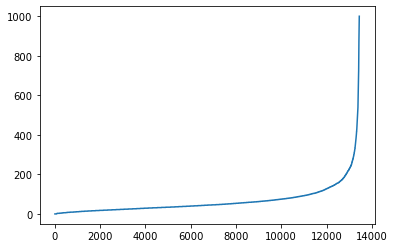

In [9]:
import matplotlib.pyplot as plt

plt.plot(sorted(lengths))
plt.show()

In [134]:

length_checker = np.vectorize(len)
train_len = length_checker(X_train)
test_len = length_checker(X_test)
X_train = X_train[train_len > 150]
Y_train = Y_train[train_len > 150]
X_test = X_test[test_len > 150]
Y_test = Y_test[test_len > 150]




## Naive Bayes

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer

steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
bayes_pipeline = Pipeline(steps)
bayes_pipeline.fit(X_train, Y_train)
print(f"Train data score: {bayes_pipeline.score(X_train, Y_train)}")
print(f"Test data score: {bayes_pipeline.score(X_test, Y_test)}")



Train data score: 0.5881272660554243
Test data score: 0.5473998468602483


## Random forest

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

steps = [('vec', CountVectorizer()), ('randomforest', RandomForestClassifier(n_estimators=200, criterion='entropy', verbose=10, n_jobs=-1))]

forest_pipeline = Pipeline(steps, verbose=True)
forest_pipeline.fit(X_train, Y_train)
print(f"Train data score: {forest_pipeline.score(X_train, Y_train)}")
print(f"Test data score: {forest_pipeline.score(X_test, Y_test)}")

## LSTM

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    

vocab_size = 30000
embedding_dim = 100
oov_tok = '<OOV>'
max_length = 350
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.astype(str))

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train.astype(str))
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
validation_sequences = tokenizer.texts_to_sequences(X_test.astype(str))
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


training_label_seq = np.array(list(map(int,Y_train)))
validation_label_seq = np.array(list(map(int, Y_test)))

NameError: name 'X_train' is not defined

### Train model

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

def get_model():
    model = Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
    model.add(LSTM(units=64, return_sequences=True, dropout=0.2))
    model.add(LSTM(units=1, dropout=0.2))
    model.add(Dense(units=1, activation='relu'))
    # Adding the output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = get_model()

model.fit(train_padded, Y_train, epochs=1, batch_size=3024)


385/385 [==============================] - 52s 134ms/step - loss: 8.3308 - accuracy: 0.4599


### Make predictions

In [30]:
probabilities = np.squeeze(model.predict(validation_padded))
predictions = np.where(probabilities > 0.5, 1, 0)
print(probabilities)

[-0.5762153 -0.5762153 -0.5762153 ... -0.5762153 -0.5762153 -0.5762153]


### Evaluate model

In [27]:
model.evaluate(validation_padded, validation_label_seq)

12122/12122 [==============================] - 99s 8ms/step - loss: 8.3052 - accuracy: 0.4616


[8.305191993713379, 0.4615693986415863]

In [28]:

right_classified = 0

for i in range(len(predictions)):
    if predictions[i] == validation_label_seq[i]:
        right_classified += 1
        
print(f"accuracy: {right_classified/len(predictions)}")
print(f"rate of positive predictions: {sum(predictions)/len(predictions)}" )
print(f"rate of positive validation labels (baseline): {sum(validation_label_seq)/len(validation_label_seq)}")
print(f"rate of negative validation labels (baseline): {1 - sum(validation_label_seq)/len(validation_label_seq)}")

accuracy: 0.46156939886202214
rate of positive predictions: 0.0
rate of positive validation labels (baseline): 0.5384306011379779
rate of negative validation labels (baseline): 0.4615693988620221


# Understanding the data

## Examining upvotes

In [89]:
scores = []
threshold = 10
average_length = 0
for comment in mongo_comments.find():
    if comment["score"] >= threshold:
        scores.append(comment["score"])
        average_length += len(comment["body"].split())
average_length = average_length / len(scores)
    

23080
22.10966204506066


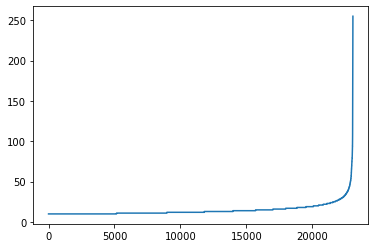

In [90]:
print(len(scores))
print(average_length)
plt.plot(sorted(scores))

plt.show()

# Proper cross validation

In [121]:
vocab_size = [10000, 100000]
filter_stopwords = [True, False]
embedding_dims = [100, 200]
lstm_layers_ammounts  = [1, 2]
nodes_in_lstm_layers = [50,100]
max_lengths = [100, 300, None]
min_lengths = [0, 50, 100]

In [122]:
runs = []

for size in vocab_size:
    for should_filter in filter_stopwords:
        for embedding_dim in embedding_dims:
            for n_lstm_layers in lstm_layers_ammounts:
                for n_lstm_nodes in nodes_in_lstm_layers:
                    for max_len in max_lengths:
                        if max_len is None:
                            for min_len in min_lengths:
                                runs.append({
                                    "vocab_size": size,
                                    "filter_stopwords": should_filter,
                                    "embedding_dim": embedding_dim,
                                    "n_lstm_layers": n_lstm_layers,
                                    "n_lstm_nodes" : n_lstm_nodes,
                                    "max_len": None,
                                    "min_len": min_len
                                })
                        else:
                            runs.append({
                                "vocab_size": size,
                                "filter_stopwords": should_filter,
                                "embedding_dim": embedding_dim,
                                "n_lstm_layers": n_lstm_layers,
                                "n_lstm_nodes" : n_lstm_nodes,
                                "max_len": max_len,
                                "min_len": 0
                            })

In [24]:
import numpy as np

def min_5_upvotes_iterator(field, threshold = 5):
    cursor = mongo_comments.find() 
    for comment in cursor:
        if comment["score"] > threshold:
            if "comment" in field:
                yield " ".join(comment[field]).encode("ascii", "ignore").decode()
            else:
                yield comment[field]

                
                
                

X_data_without_stop = np.fromiter(iter(min_5_upvotes_iterator("preprocessed_comment_without_stop")), 'S1000')
X_data = np.fromiter(iter(min_5_upvotes_iterator("preprocessed_comment")), 'S1000')
Y_data = np.fromiter(iter(min_5_upvotes_iterator("next_trading_day_positive")), bool)

number_of_comments = len(X_data)

if sum(Y_data)/number_of_comments > 0.5:
    
    number_to_remove = sum(Y_data) - (number_of_comments-sum(Y_data))
    indexes_to_remove = np.random.choice(np.where(Y_data == 1)[0], number_to_remove, replace = False)
else:
    number_to_remove = (number_of_comments-sum(Y_data)) - sum(Y_data)
    indexes_to_remove = np.random.choice(np.where(Y_data == 0)[0], number_to_remove, replace = False)

X_data_without_stop = np.delete(X_data_without_stop, indexes_to_remove)
X_data = np.delete(X_data, indexes_to_remove)
Y_data = np.delete(Y_data, indexes_to_remove)

number_of_comments = len(X_data)
indices = np.arange(0, number_of_comments)
np.random.shuffle(indices)

X_data_without_stop = X_data_without_stop[indices]
X_data = X_data[indices]
Y_data = Y_data[indices]




In [25]:
def get_data(filter_stopwords, min_len, max_len):
    number_of_comments = len(X_data)

    train_threshold = 0.70
    train_end = int(train_threshold * number_of_comments)
    
    valid_threshold = 0.85
    valid_end = int(valid_threshold * number_of_comments)

    if filter_stopwords:
        x_train = X_data_without_stop[:train_end]
        x_test = X_data_without_stop[train_end:valid_end]
    else:
        x_train = X_data[:train_end]
        x_test = X_data[train_end:valid_end]

    y_train = Y_data[:train_end]
    y_test = Y_data[train_end:valid_end]
    

    length_checker = np.vectorize(len)
    train_len = length_checker(x_train)
    test_len = length_checker(x_test)

    if max_len is not None:
        x_train = x_train[train_len < max_len]
        y_train = y_train[train_len < max_len]
        x_test = x_test[test_len < max_len]
        y_test = y_test[test_len < max_len]

    elif min_len > 0:
        x_train = x_train[train_len > min_len]
        y_train = y_train[train_len > min_len]
        x_test = x_test[test_len > min_len]
        y_test = y_test[test_len > min_len]
    
    return x_train, y_train, x_test, y_test
print(len(X_data))

68926


In [ ]:
mongo_cv_results = db["cv_results"]




for run in runs:
    vocab_size = run["vocab_size"]
    filter_stopwords = run["filter_stopwords"]
    embedding_dim = run["embedding_dim"]
    n_lstm_layers = run["n_lstm_layers"]
    n_lstm_nodes = run["n_lstm_nodes"]
    max_len = run["max_len"]
    min_len = run["min_len"]
    
    x_train, y_train, x_test, y_test = get_data(filter_stopwords, min_len, max_len)
    
    
    if len(tf.config.list_physical_devices('GPU')):
        physical_devices = tf.config.list_physical_devices('GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    
    oov_tok = '<OOV>'
    max_length = 500
    trunc_type = 'post'
    padding_type = 'post'
    
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(x_train.astype(str))

    word_index = tokenizer.word_index

    train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    validation_sequences = tokenizer.texts_to_sequences(x_test.astype(str))
    validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


    training_label_seq = np.array(list(map(int,y_train)))
    validation_label_seq = np.array(list(map(int, y_test)))
    
    model = Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
    
    for i in range(n_lstm_layers):
        if n_lstm_layers > 1 and i+1 != n_lstm_layers:
            model.add(LSTM(units=n_lstm_nodes, return_sequences=True, dropout=0.1))
        else:
            model.add(LSTM(units=n_lstm_nodes, dropout=0.1))
    
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(train_padded, y_train, epochs=3, batch_size=32)
    loss, accuracy = model.evaluate(validation_padded, validation_label_seq)
    probabilities = np.squeeze(model.predict(validation_padded))
    predictions = np.where(probabilities > 0.5, 1, 0)
    results = {
        "parameters": run,
        "loss": loss,
        "accuracy": accuracy,
    }
    print(f"------------Results-------------")
    print("parameters:", run)
    print("loss:", loss)
    print("accuracy", accuracy)
    mongo_cv_results.insert_one(results)


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

x_train, y_train, x_test, y_test = get_data(filter_stopwords = True, min_len = 0, max_len = None)

steps= [('vec', TfidfVectorizer()), ('multinomialnb', MultinomialNB())]
bayes_pipeline = Pipeline(steps)
bayes_pipeline.fit(x_train, y_train)
print(f"Train data score: {bayes_pipeline.score(x_train, y_train)}")
print(f"Test data score: {bayes_pipeline.score(x_test, y_test)}")

pred = bayes_pipeline.predict(x_test)
print(classification_report(y_test, pred, labels =[0, 1]))
print(confusion_matrix(y_test, pred, labels=[0,1]))


Train data score: 0.7011482341236942
Test data score: 0.5578876100203114
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      5124
           1       0.56      0.55      0.55      5215

    accuracy                           0.56     10339
   macro avg       0.56      0.56      0.56     10339
weighted avg       0.56      0.56      0.56     10339

[[2923 2201]
 [2370 2845]]


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

steps = [('vec', CountVectorizer()), ('randomforest', RandomForestClassifier(n_estimators=200, criterion='entropy', verbose=0, n_jobs=-1))]
x_train, y_train, x_test, y_test = get_data(filter_stopwords = False, min_len = 0, max_len = None)

forest_pipeline = Pipeline(steps, verbose=True)
forest_pipeline.fit(x_train, y_train)

print(f"Train data score: {forest_pipeline.score(x_train, y_train)}")
print(f"Test data score: {forest_pipeline.score(x_test, y_test)}")

[Pipeline] ............... (step 1 of 2) Processing vec, total=   0.3s
[Pipeline] ...... (step 2 of 2) Processing randomforest, total=  17.3s
Train data score: 0.9820303432266623
Test data score: 0.5442499274591354


0.5107857491459249


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 100000
filter_stopwords = True
embedding_dim = 10
max_len = 300
min_len = 0

x_train, y_train, x_test, y_test = get_data(filter_stopwords, min_len, max_len)


if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

oov_tok = '<OOV>'
max_length = 300
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train.astype(str))

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(x_test.astype(str))
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


training_label_seq = np.array(list(map(int,y_train)))
validation_label_seq = np.array(list(map(int, y_test)))

model = Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))

model.add(LSTM(units=50, return_sequences=True, dropout=0))
model.add(LSTM(units=50, return_sequences=True, dropout=0))
model.add(LSTM(units=50, return_sequences=True, dropout=0))
model.add(LSTM(units=50, dropout=0))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_padded, y_train,validation_data = (validation_padded, validation_label_seq), epochs=10, batch_size=32)
loss, accuracy = model.evaluate(validation_padded, validation_label_seq)
probabilities = np.squeeze(model.predict(validation_padded))


predictions = np.where(probabilities > 0.5, 1, 0)
results = {
    "parameters": run,
    "loss": loss,
    "accuracy": accuracy,
}
print(f"------------Results-------------")
print("parameters:", run)
print("loss:", loss)
print("accuracy", accuracy)

Epoch 1/10
   9/1494 [..............................] - ETA: 4:25 - loss: 7.6054 - accuracy: 0.5069

KeyboardInterrupt: 

In [10]:
print(mongo_comments.find().count())

1551522


<ipython-input-10-98ed78db9d0c>:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  print(mongo_comments.find().count())


In [43]:
train_padded

array([[1893,  562,  172, ...,    0,    0,    0],
       [  11,  829,   17, ...,    0,    0,    0],
       [9982,  141,    0, ...,    0,    0,    0],
       ...,
       [ 318,  219,  658, ...,    0,    0,    0],
       [1291,  815,    0, ...,    0,    0,    0],
       [ 596,  897, 4534, ...,    0,    0,    0]], dtype=int32)

In [39]:
mongo_cv_results = db["cv_results"]
best_accuracy = 0

for result in mongo_cv_results.find():
    if result["accuracy"] > best_accuracy:
        best_accuracy = result["accuracy"]
        print(result)


{'_id': ObjectId('5ffb425c78dd39d999d19678'), 'parameters': {'vocab_size': 10000, 'filter_stopwords': True, 'embedding_dim': 100, 'n_lstm_layers': 1, 'n_lstm_nodes': 50, 'max_len': 100, 'min_len': 0}, 'loss': 0.6933472752571106, 'accuracy': 0.49875903129577637}
{'_id': ObjectId('5ffb42b078dd39d999d19679'), 'parameters': {'vocab_size': 10000, 'filter_stopwords': True, 'embedding_dim': 100, 'n_lstm_layers': 1, 'n_lstm_nodes': 50, 'max_len': 300, 'min_len': 0}, 'loss': 7.677075386047363, 'accuracy': 0.5022947192192078}
{'_id': ObjectId('5ffb430478dd39d999d1967a'), 'parameters': {'vocab_size': 10000, 'filter_stopwords': True, 'embedding_dim': 100, 'n_lstm_layers': 1, 'n_lstm_nodes': 50, 'max_len': None, 'min_len': 0}, 'loss': 7.672938346862793, 'accuracy': 0.5025631189346313}
{'_id': ObjectId('5ffb432178dd39d999d1967b'), 'parameters': {'vocab_size': 10000, 'filter_stopwords': True, 'embedding_dim': 100, 'n_lstm_layers': 1, 'n_lstm_nodes': 50, 'max_len': None, 'min_len': 50}, 'loss': 0.6931

In [40]:
print(x_train)

[b'amrn crush earning barely budge post market fml guess hold call till expiry'
 b'future bulls fucking retard fun homeless' b'edgelord tonight' ...
 b'send mod course video lick homeless mans r wallstreetbet comment reverse vacation'
 b'll ally' b'weekly reminder lebron james selfish piece shit']
